## Sentiment Analysis on Airline Tweets Dataset


In [1]:
# import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score

import string
import re
import nltk
#import spacy

In [2]:
# read csv dataset
df = pd.read_csv("c:/Users/Windows/Downloads/data/Tweets.csv")

In [3]:
# check the first 3 date points
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [89]:
# check the shape
df.shape

(14640, 15)

In [4]:
# check the data structure and data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [6]:
# check missing values. for this NLP project, we will focus on two independable variables: airline sentiment and text.
# fortunately, these two clumns have no missing values.
df.isna().sum()/df.shape[0]

tweet_id                        0.000000
airline_sentiment               0.000000
airline_sentiment_confidence    0.000000
negativereason                  0.373087
negativereason_confidence       0.281284
airline                         0.000000
airline_sentiment_gold          0.997268
name                            0.000000
negativereason_gold             0.997814
retweet_count                   0.000000
text                            0.000000
tweet_coord                     0.930396
tweet_created                   0.000000
tweet_location                  0.323292
user_timezone                   0.329235
dtype: float64

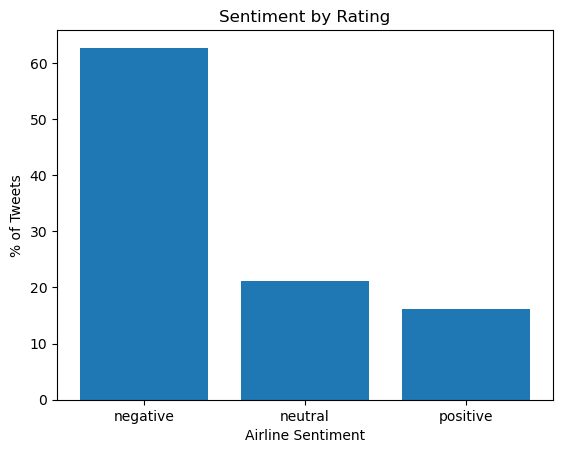

In [7]:
# let's look at the distribution of "airline_sentiment"
values,counts = np.unique(df["airline_sentiment"], return_counts=True)
normalized_counts = counts/counts.sum()

plt.figure()
plt.bar(values,normalized_counts*100)
plt.xlabel("Airline Sentiment")
plt.ylabel("% of Tweets")
plt.title("Sentiment by Rating")
plt.show()


In [93]:
normalized_counts

array([0.62691257, 0.21168033, 0.1614071 ])

Without further modeling, randam gusss can give us 62% accuracy at most.

In [8]:
df.groupby('negativereason')['negativereason'].count().sort_values(ascending=False)

negativereason
Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Customer Service Issue'),
  Text(1, 0, 'Late Flight'),
  Text(2, 0, "Can't Tell"),
  Text(3, 0, 'Cancelled Flight'),
  Text(4, 0, 'Lost Luggage'),
  Text(5, 0, 'Bad Flight'),
  Text(6, 0, 'Flight Booking Problems'),
  Text(7, 0, 'Flight Attendant Complaints'),
  Text(8, 0, 'longlines'),
  Text(9, 0, 'Damaged Luggage')])

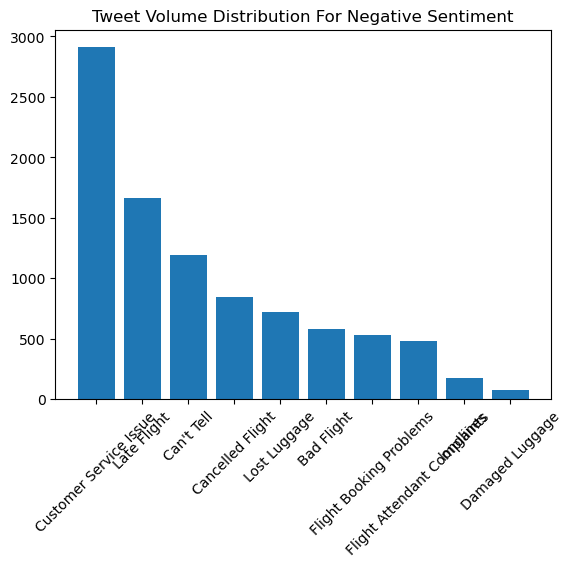

In [10]:
df_by_negativereason = df.groupby('negativereason')['negativereason'].count().sort_values(ascending=False)

plt.bar(df_by_negativereason.index,df_by_negativereason)
plt.title('Tweet Volume Distribution For Negative Sentiment')
plt.xticks(rotation=45)

In [16]:
df_sentiment_by_airline = df.groupby(['airline', 'airline_sentiment'])['airline'].count()/df.groupby("airline")["airline"].count()

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 640x480 with 0 Axes>

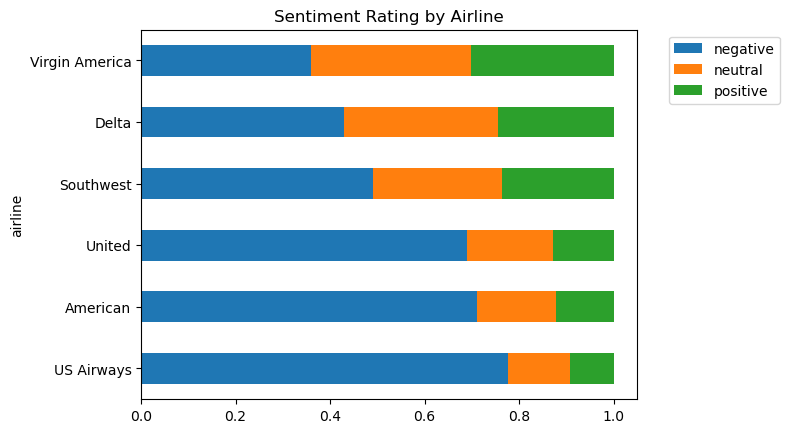

In [17]:
plt.figure()
df_sentiment_by_airline.unstack().sort_values(by="positive").plot(kind="barh",stacked=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Sentiment Rating by Airline")
plt.show

### The Bag-of-Words model

In [19]:
# spliting the data into training and test set
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
X = df["text"]
y = df["airline_sentiment"]
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.33 ,random_state=42)

In [20]:
X_train.values

array(['@JetBlue of course I am!!✈️',
       '@AmericanAir complt incompetence on flt 295.Lav delay from a pln that lnded last nite, no internet and poor svc. Not what I expect from u.',
       '@SouthwestAir Flight 4968 (N8325D) departs @MCO enroute to @NO_Airport http://t.co/fd4SnvKIeM',
       ...,
       '@SouthwestAir Been on hold for over an hour - any chance someone can help me on here?',
       '@united we would...how do I contact you to discuss? A few poor experiences with customer service but would give it a shot!',
       "@JetBlue that's ok! It just sure seemed like it when JetBlue tweeted us back and asked us to send selfies of us watching.. Haha"],
      dtype=object)

In [96]:
# size of training set
X_train.shape

(9808,)

In [23]:
# making a document-term matrix
bagofwords = CountVectorizer()
bagofwords.fit(X_train)
X_train_transformed = bagofwords.transform(X_train)
X_train_transformed

<9808x12056 sparse matrix of type '<class 'numpy.int64'>'
	with 156290 stored elements in Compressed Sparse Row format>

we can see the 12,056 unique tokens

Text(0.5, 1.0, 'Tweets Length Distribution')

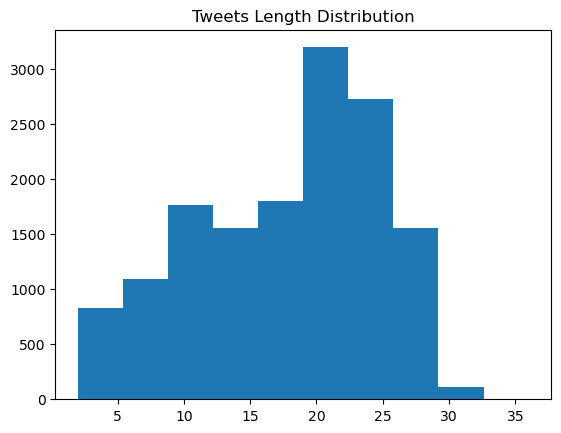

In [21]:
text_lengths = X.apply(lambda text: len(text.split())) 
plt.hist(text_lengths)
plt.title("Tweets Length Distribution")

In [24]:
# transforming the test set 
X_test_transformed = bagofwords.transform(X_test)
X_test_transformed

<4832x12056 sparse matrix of type '<class 'numpy.int64'>'
	with 74703 stored elements in Compressed Sparse Row format>

In [25]:
# Looking at the frequent tokens 
len(bagofwords.get_feature_names_out())

12056

In [26]:
X_train_transformed.sum(axis=0)

matrix([[ 9, 15,  1, ...,  1,  1,  1]], dtype=int64)

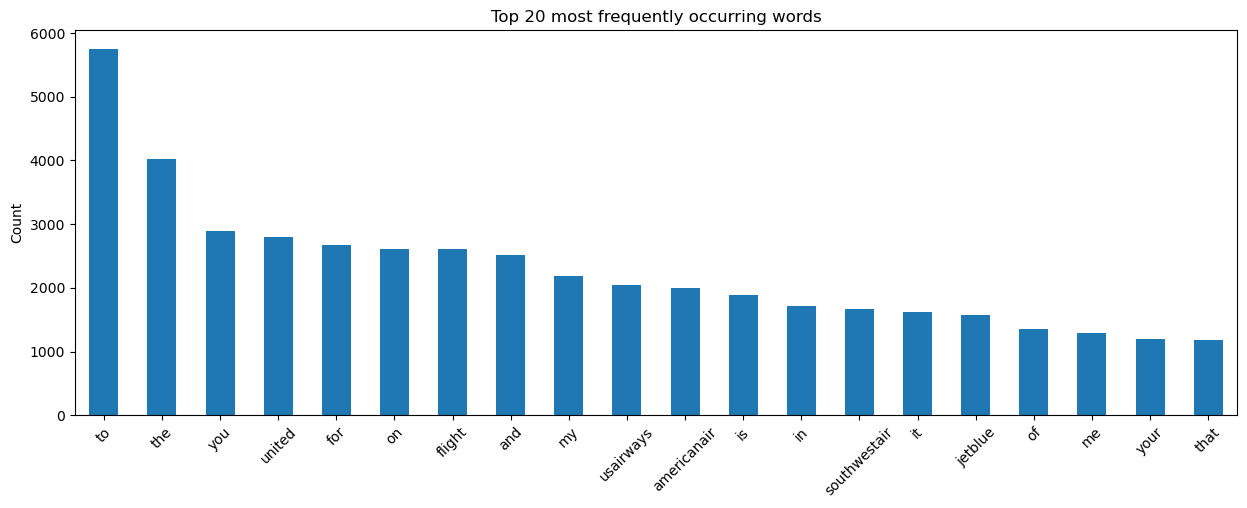

In [27]:
word_counts = pd.DataFrame({"counts": X_train_transformed.toarray().sum(axis=0)},
                           index = bagofwords.get_feature_names_out()).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar",figsize=(15,5),legend=False)
plt.title("Top 20 most frequently occurring words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [28]:
# Solving Stopwords problem
# easiest way to remove stop words
bagofwords = CountVectorizer(stop_words="english")
bagofwords.fit(X_train)

X_train_transformed = bagofwords.transform(X_train) 
X_test_transformed = bagofwords.transform(X_test) 

X_train_transformed.shape

(9808, 11777)

In [ ]:
# the number of tokens has been reduced from 12056 to 11777.

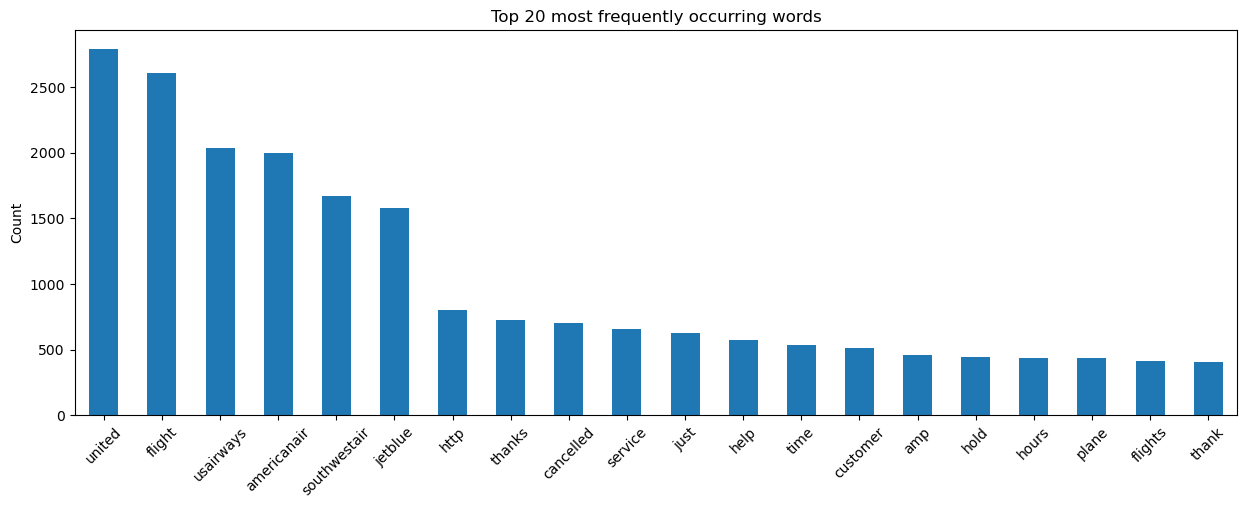

In [29]:
word_counts = pd.DataFrame(
    {"counts": X_train_transformed.toarray().sum(axis=0)},
    index=bagofwords.get_feature_names_out()
).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

### Fitting a LogisticRegression model

In [105]:
term_doc = pd.DataFrame(X_train_transformed.toarray(),
                        columns=bagofwords.get_feature_names_out())
term_doc.sample(5)

,00,000,000114,000ft,0011,0016,00a,00am,00p,00pm,...,zoom,zqutus7epw,zrh_airport,zsdgzydnde,zsuztnaijq,ztrdwv0n4l,zurich,zv2pt6trk9,zv6cfpohl5,zvfmxnuelj
960,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7949,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8266,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7734,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8411,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [106]:
# fitting a model
logreg = LogisticRegression(C=0.1)
logreg.fit(X_train_transformed,y_train)
print(f"Train score: {logreg.score(X_train_transformed,y_train)}")
print(f"Test score: {logreg.score(X_test_transformed,y_test)}")

Train score: 0.8372756933115824
Test score: 0.7775248344370861


### Fitting a KNN model

In [112]:
from sklearn.neighbors import KNeighborsClassifier

KNN_model = KNeighborsClassifier(n_neighbors=50)
KNN_model.fit(X_train_transformed, y_train)

train_predictions = KNN_model.predict(X_train_transformed)
test_predictions = KNN_model.predict(X_test_transformed)
train_accuracy = accuracy_score(train_predictions,y_train)
test_accuracy = accuracy_score(test_predictions,y_test)

print(f"Train accuracy: {train_accuracy}")
print(f"Test accuracy: {test_accuracy}")

Train accuracy: 0.48643964110929855
Test accuracy: 0.4375


In [66]:
X_train_transformed.shape[0]

9808

### Fitting Decision Tree model

In [116]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(max_depth=6)
dt_model.fit(X_train_transformed, y_train)

train_predictions = dt_model.predict(X_train_transformed)
test_predictions = dt_model.predict(X_test_transformed)
train_accuracy = accuracy_score(train_predictions,y_train)
test_accuracy = accuracy_score(test_predictions,y_test)

print(f"Train accuracy: {train_accuracy}")
print(f"Test accuracy: {test_accuracy}") 

Train accuracy: 0.6888254486133768
Test accuracy: 0.6926738410596026
